In [1]:
import gym
from gym import wrappers

from collections import deque
import numpy as np
import scipy.signal
import tensorflow as tf
from sklearn.utils import shuffle

import argparse
import pprint as pp
import random

seed = 0
np.random.seed(seed)

# Helper Function for Visualization

In [2]:
# Imports specifically so we can render outputs in Jupyter.
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display
from matplotlib import pyplot as plt


def display_frames_as_gif(frames):
    patch = plt.imshow(frames[0])
    plt.axis('off')
    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=5)
    display(display_animation(anim, default_mode='loop'))

# Replay Buffer

In [3]:
class ReplayBuffer(object):

    def __init__(self, buffer_size, random_seed=123):
        """
        The right side of the deque contains the most recent experiences 
        """
        self.buffer_size = buffer_size
        self.count = 0
        self.buffer = deque()
        random.seed(random_seed)

    def add(self, s, a, r, t, s2):
        experience = (s, a, r, t, s2)
        if self.count < self.buffer_size: 
            self.buffer.append(experience)
            self.count += 1
        else:
            self.buffer.popleft()
            self.buffer.append(experience)

    def size(self):
        return self.count

    def sample_batch(self, batch_size):
        batch = []

        if self.count < batch_size:
            batch = random.sample(self.buffer, self.count)
        else:
            batch = random.sample(self.buffer, batch_size)

        s_batch = np.array([_[0] for _ in batch])
        a_batch = np.array([_[1] for _ in batch])
        r_batch = np.array([_[2] for _ in batch])
        t_batch = np.array([_[3] for _ in batch])
        s2_batch = np.array([_[4] for _ in batch])

        return s_batch, a_batch, r_batch, t_batch, s2_batch

    def clear(self):
        self.buffer.clear()
        self.count = 0

# Actor Network

### Define deterministic policy function $\mu_{\theta}(s)$ and target policy function $\mu'_{\theta'}(s)$

In [12]:
class ActorNetwork(object):
    def __init__(self, sess, obs_dim, act_dim, act_min, act_max, lr=1e-4, tau=1e-3, batch_size=64, hdim = 64):
        self.sess = sess
        self.obs_dim = obs_dim
        self.act_dim = act_dim
        self.act_min = act_min
        self.act_max = act_max
        
        self.hdim = hdim
        self.lr = lr
        
        self.tau = tau # Parameter for soft update
        self.batch_size = batch_size
        
        self.seed = 0

        # Actor Network
        self.inputs, self.out = self.create_actor_network(scope='actor')
        self.network_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='actor')

        # Target Network
        self.target_inputs, self.target_out = self.create_actor_network(scope='target_actor')
        self.target_network_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='target_actor')
        
        # Parameter Updating Operator
        self.update_target_network_params = [self.target_network_params[i].assign(
            tf.multiply(self.network_params[i], self.tau) + tf.multiply(self.target_network_params[i], 1. - self.tau)) for i in range(len(self.target_network_params))]

        # Gradient will be provided by the critic network
        self.action_gradient = tf.placeholder(tf.float32, [None, self.act_dim])

        # Combine the gradients here
        self.unnormalized_actor_gradients = tf.gradients(self.out, self.network_params, -self.action_gradient)
#         self.actor_gradients = list(map(lambda x: x/self.batch_size, self.unnormalized_actor_gradients))
        self.actor_gradients = [ unnz_actor_grad/self.batch_size for unnz_actor_grad in self.unnormalized_actor_gradients]

        # Optimizer
        self.optimize = tf.train.AdamOptimizer(self.lr).apply_gradients(zip(self.actor_gradients, self.network_params))

        self.num_trainable_vars = len(self.network_params) + len(self.target_network_params)

    def create_actor_network(self,scope='network'):
        hid1_size = self.hdim
        hid2_size = self.hdim
        
        with tf.variable_scope(scope): # Two Layer Network
            
            # Input Placeholder
            inputs = tf.placeholder(tf.float32, (None, self.obs_dim), 'obs')
            
            out = tf.layers.dense(inputs, hid1_size, tf.tanh,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed=self.seed), name="h1")
            out = tf.layers.dense(out, hid2_size, tf.tanh, # Tangent Hyperbolic Activation
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed=self.seed), name='hidden2')
            out = tf.layers.dense(out, self.act_dim, # Linear Layer
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed=self.seed), name='act')
            out = tf.sigmoid(out)*(self.act_max-self.act_min) + self.act_min
        return inputs, out

    def train(self, inputs, a_gradient):
        self.sess.run(self.optimize, feed_dict={
            self.inputs: inputs,
            self.action_gradient: a_gradient
        })

    def predict(self, inputs):
        return self.sess.run(self.out, feed_dict={
            self.inputs: inputs
        })

    def predict_target(self, inputs):
        return self.sess.run(self.target_out, feed_dict={
            self.target_inputs: inputs
        })

    def update_target_network(self):
        self.sess.run(self.update_target_network_params)

    def get_num_trainable_vars(self):
        return self.num_trainable_vars

# Critic Network

### Define critic network $Q_{\phi}(s,a)$ and target critic network  $Q'_{\phi'}(s,a)$

In [13]:
class CriticNetwork(object):
    def __init__(self, sess, obs_dim, act_dim, learning_rate=1e-3, tau=1e-3, gamma=0.995, hidden_unit_size = 64):
        self.sess = sess
        self.obs_dim = obs_dim
        self.act_dim = act_dim
        self.hidden_unit_size = hidden_unit_size
        self.learning_rate = learning_rate
        self.tau = tau
        self.gamma = gamma
        self.seed = 0

        # Create the critic network
        self.inputs, self.action, self.out = self.buil_critic_nn(scope='critic')
        self.network_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='critic')

        # Target Network
        self.target_inputs, self.target_action, self.target_out = self.buil_critic_nn(scope='target_critic')
        self.target_network_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='target_critic')

        # Op for periodically updating target network with online network
        # weights with regularization
        self.update_target_network_params = [self.target_network_params[i].assign(tf.multiply(self.network_params[i], self.tau) + tf.multiply(self.target_network_params[i], 1. - self.tau))
                for i in range(len(self.target_network_params))]

        # Network target (y_i)
        self.predicted_q_value = tf.placeholder(tf.float32, [None, 1])

        # Define loss and optimization Op
        self.loss = tf.reduce_mean(tf.squared_difference(self.predicted_q_value, self.out))
        self.optimize = tf.train.AdamOptimizer(
            self.learning_rate).minimize(self.loss)

        # Get the gradient of the net w.r.t. the action.
        # For each action in the minibatch (i.e., for each x in xs),
        # this will sum up the gradients of each critic output in the minibatch
        # w.r.t. that action. Each output is independent of all
        # actions except for one.
        self.action_grads = tf.gradients(self.out, self.action)
        
    def buil_critic_nn(self,scope='network'):
        hid1_size = self.hidden_unit_size
        hid2_size = self.hidden_unit_size
        
        with tf.variable_scope(scope): # Prediction Network / Two layered perceptron / Training Parameters
            inputs = tf.placeholder(tf.float32, (None, self.obs_dim), 'obs')
            action = tf.placeholder(tf.float32, (None, self.act_dim), 'act')
            out = tf.layers.dense(tf.concat([inputs,action],axis=1), hid1_size, tf.tanh,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed=self.seed), name="h1")
            out = tf.layers.dense(out, hid2_size, tf.tanh, # Tangent Hyperbolic Activation
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed=self.seed), name='h2')
            out = tf.layers.dense(out, 1, # Linear Layer
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed=self.seed), name='q')
        return inputs, action, out
    
    def train(self, inputs, action, predicted_q_value):
        return self.sess.run([self.out, self.optimize], feed_dict={
            self.inputs: inputs,
            self.action: action,
            self.predicted_q_value: predicted_q_value
        })

    def predict(self, inputs, action):
        return self.sess.run(self.out, feed_dict={
            self.inputs: inputs,
            self.action: action
        })

    def predict_target(self, inputs, action):
        return self.sess.run(self.target_out, feed_dict={
            self.target_inputs: inputs,
            self.target_action: action
        })

    def action_gradients(self, inputs, actions):
        return self.sess.run(self.action_grads, feed_dict={
            self.inputs: inputs,
            self.action: actions
        })

    def update_target_network(self):
        self.sess.run(self.update_target_network_params)

# Action Noise

### $\mu_{\theta}(s) + \mathcal{N}_{t}$

### 1. Ornstein-Uhlenbeck process

### we used an Ornstein-Uhlenbeck process (Uhlenbeck & Ornstein, 1930) to generate temporally correlated exploration for exploration efficiency in physical control problems with inertia
### Ornstein-Uhlenbeck process describes the velocity of a massive Brownian particle under the influence of friction

### $dx_{t}=\theta (\mu - x_t) dt + \sigma dW_{t}$

### $dW_{t} \sim \mathcal{N}(0,I)$

### $\mu_{\theta}(s) + dx_{t}$

### 2. Simple normal distribution

### $\epsilon \sim \mathcal{N}(0,\sigma I)$

### $\mu_{\theta}(s) + \epsilon$

In [14]:
# Ornstein-Uhlenbeck Process
class OrnsteinUhlenbeckActionNoise:
    def __init__(self, mu, sigma=0.3, theta=.15, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

    def __repr__(self):
        return 'OrnsteinUhlenbeckActionNoise(mu={}, sigma={})'.format(self.mu, self.sigma)
    
# Normal distribution
class NormalActionNoise:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma

    def __call__(self):
        return np.random.normal(self.mu, self.sigma)

    def __repr__(self):
        return 'NormalActionNoise(mu={}, sigma={})'.format(self.mu, self.sigma)

# Define Network and Environment

In [20]:
tf.reset_default_graph()
sess=tf.Session()

seed = 0

env = gym.make('Pendulum-v0')
np.random.seed(seed)
tf.set_random_seed(seed)
env.seed(seed)

obs_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_max = env.action_space.high
action_min = env.action_space.low

# Actor, Critic, Noise(OrnsteinUhlenbeck)
actor = ActorNetwork(sess, obs_dim, action_dim, action_min, action_max)
critic = CriticNetwork(sess, obs_dim, action_dim)
actor_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(action_dim))

sess.run(tf.global_variables_initializer())
actor.update_target_network()
critic.update_target_network()

# Memory Size 10000
replay_buffer = ReplayBuffer(10000, seed)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


# Train

In [ ]:
max_episodes = 5000
max_episode_len = env.spec.max_episode_steps
avg_return_list = deque(maxlen=10)
for i in range(max_episodes+1):

    obs = env.reset()

    ep_reward = 0
    ep_ave_max_q = 0

    for j in range(max_episode_len):

        # Added exploration noise
        action = actor.predict(np.reshape(obs, (1, actor.obs_dim))) + actor_noise()

        next_obs, reward, done, info = env.step(action[0])

        replay_buffer.add(np.reshape(obs, (actor.obs_dim,)), np.reshape(action, (actor.act_dim,)), reward,
                          done, np.reshape(next_obs, (actor.obs_dim,)))

        # Keep adding experience to the memory until
        # there are at least minibatch size samples
        if replay_buffer.size() >  actor.batch_size:
            o_batch, a_batch, r_batch, d_batch, no_batch = replay_buffer.sample_batch(actor.batch_size)

            # Calculate targets
            target_q = critic.predict_target(
                no_batch, actor.predict_target(no_batch))

            y_i = []
            for k in range(actor.batch_size):
                if d_batch[k]:
                    y_i.append(r_batch[k])
                else:
                    y_i.append(r_batch[k] + critic.gamma * target_q[k])

            # Update the critic given the targets
            predicted_q_value, _ = critic.train(
                o_batch, a_batch, np.reshape(y_i, (actor.batch_size, 1)))

            ep_ave_max_q += np.amax(predicted_q_value)

            # Update the actor policy using the sampled gradient
            a_outs = actor.predict(o_batch)
            grads = critic.action_gradients(o_batch, a_outs)
            actor.train(o_batch, grads[0])

            # Update target networks
            actor.update_target_network()
            critic.update_target_network()

        obs = next_obs
        ep_reward += reward
        if done:            
            break
    avg_return_list.append(ep_reward)
    if (i%500)==0:
        print('[{}/{}] return : {:.3f}, da : {:.3f}'.format(i,max_episodes, np.mean(avg_return_list), np.mean(actor_noise.x_prev)))
    
    if (np.mean(avg_return_list) > -180): # Threshold return to success cartpole
        print('[{}/{}] return : {:.3f}, da : {:.3f}'.format(i,max_episodes, np.mean(avg_return_list), np.mean(actor_noise.x_prev)))
        print('The problem is solved with {} episodes'.format(i))
        break

[0/5000] return : -1702.920, da : 0.344


# Evaluation

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Total Reward : -117.28



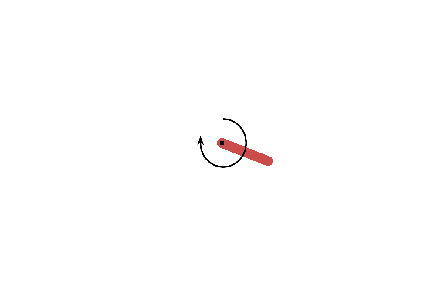
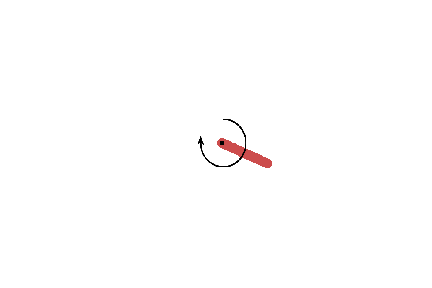
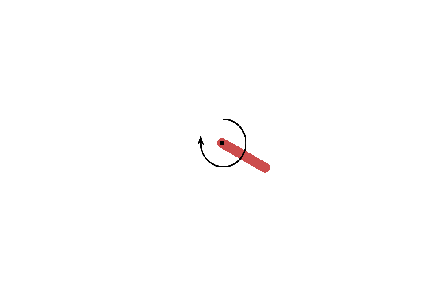
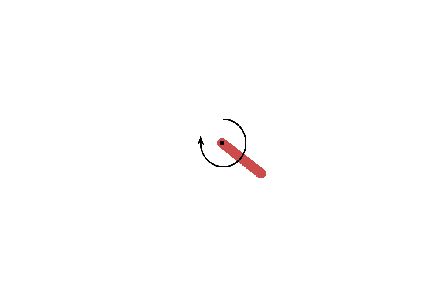
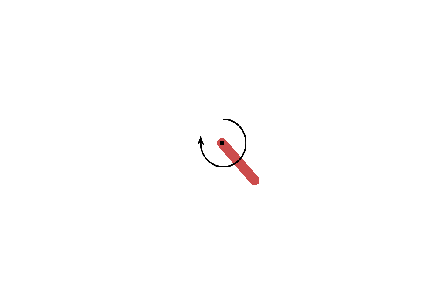
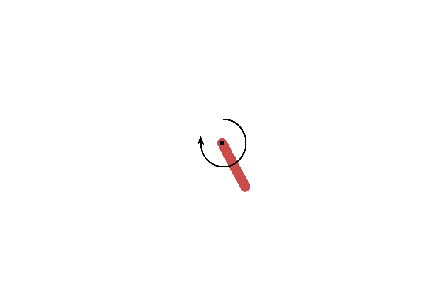
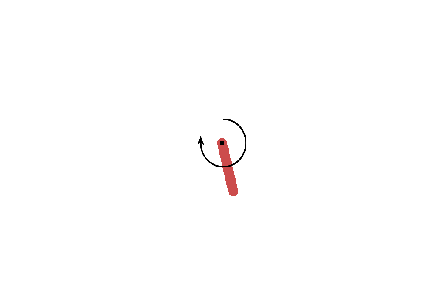
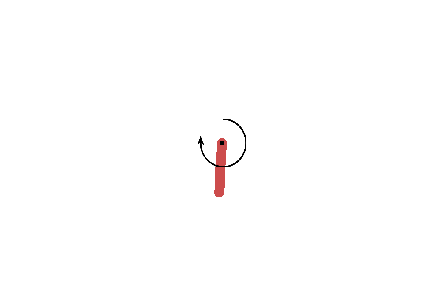
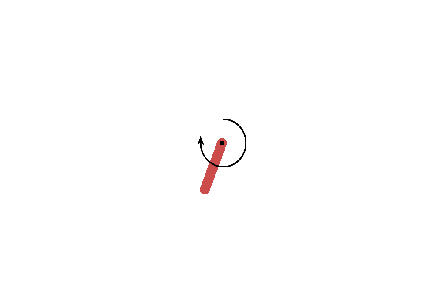
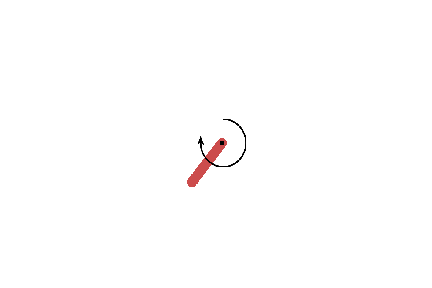
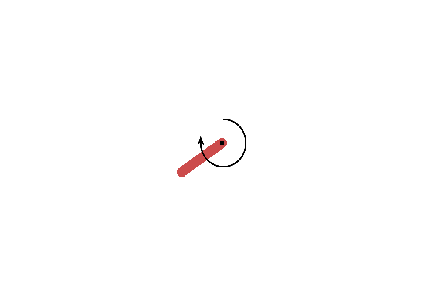
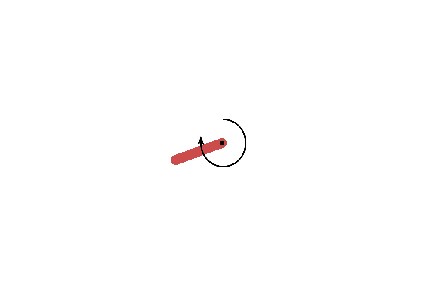
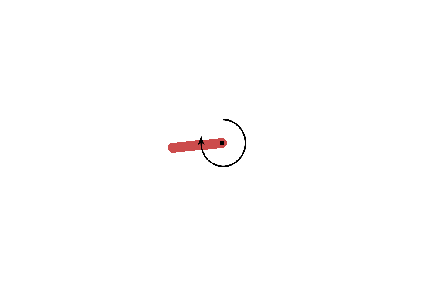
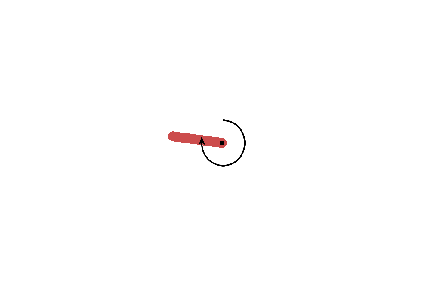
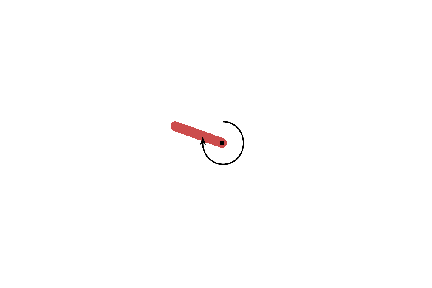
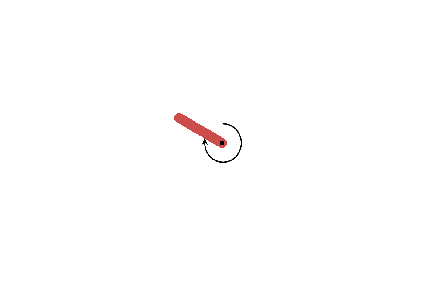
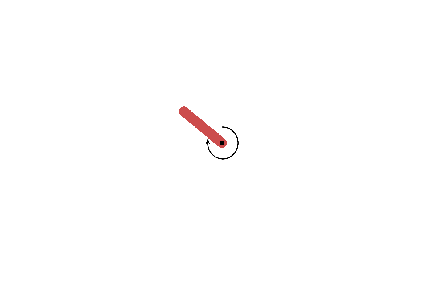
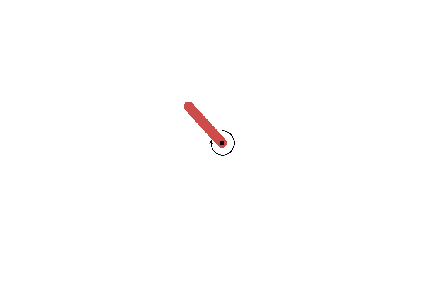
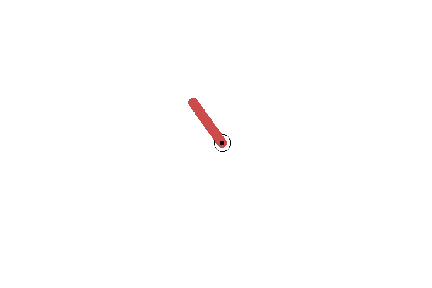
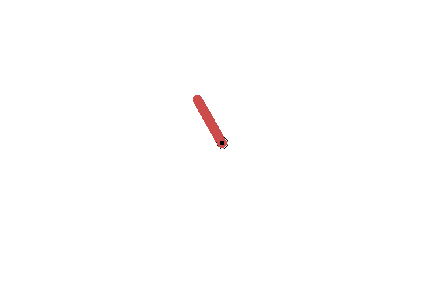
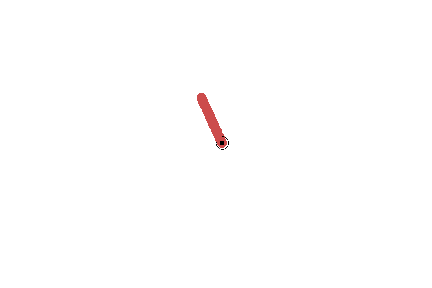
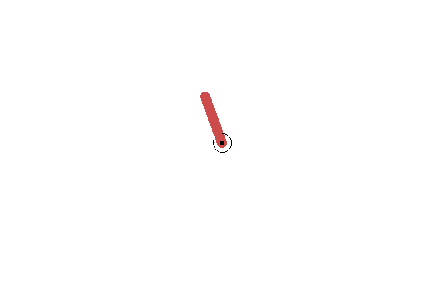
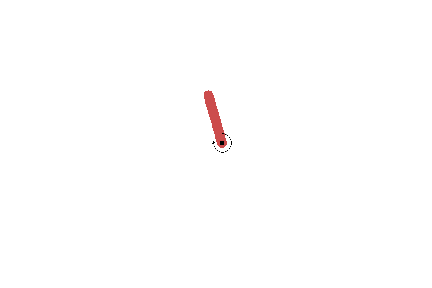
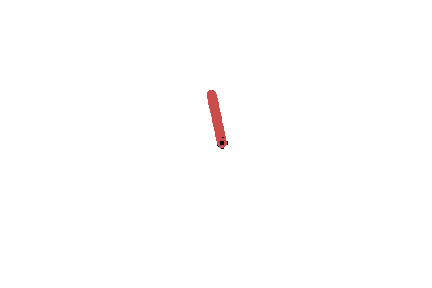
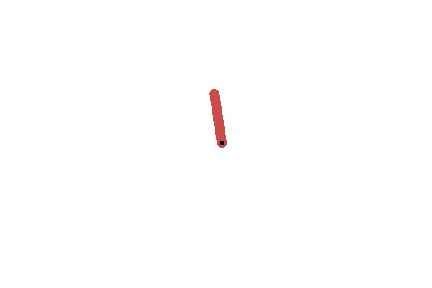
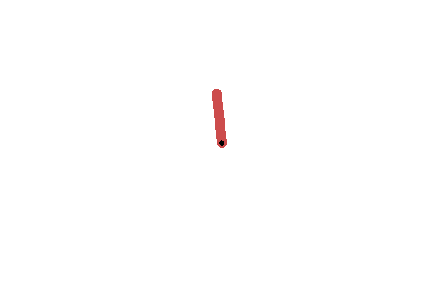
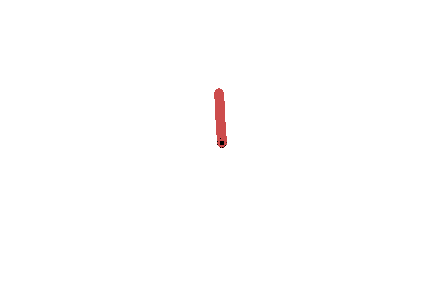
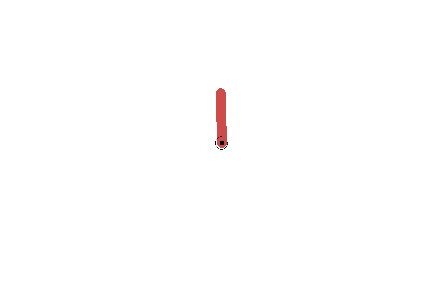
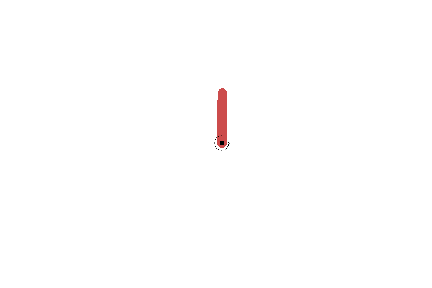
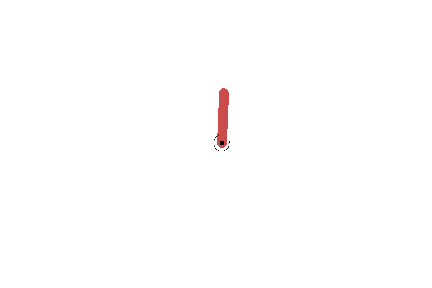
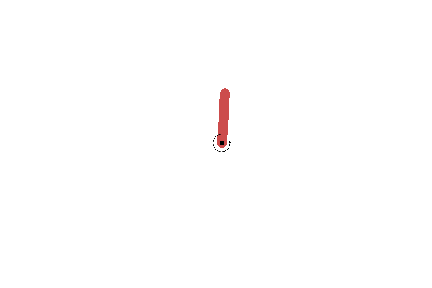
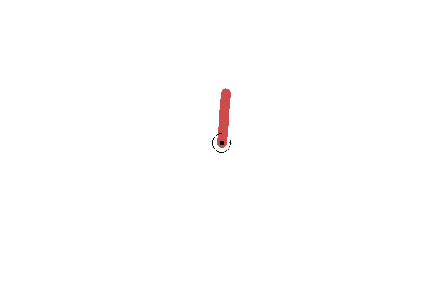
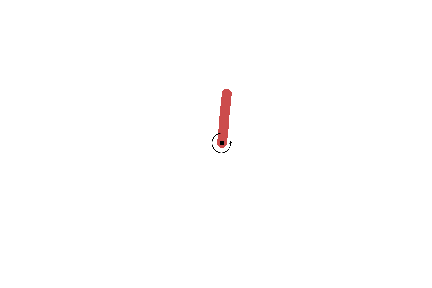
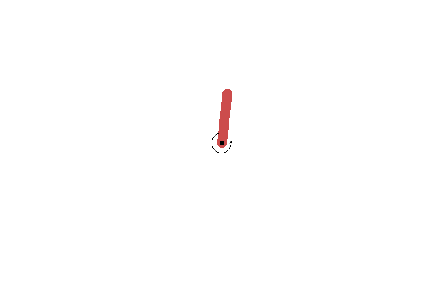
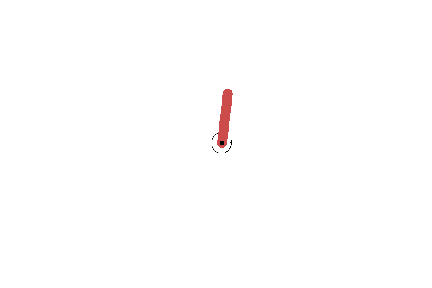
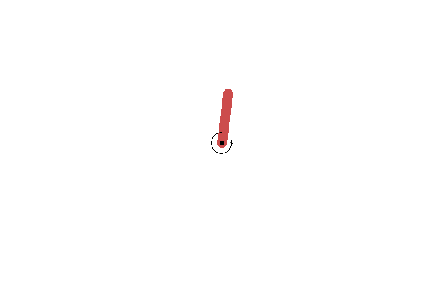
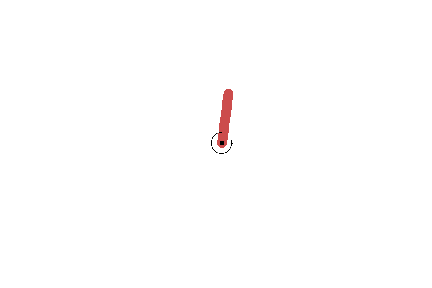
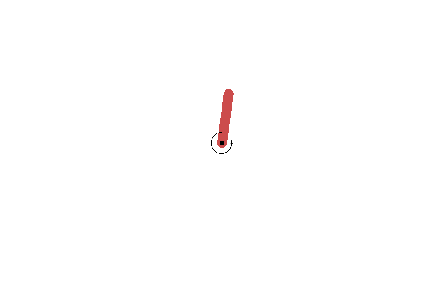
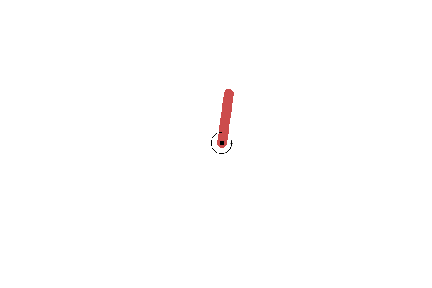
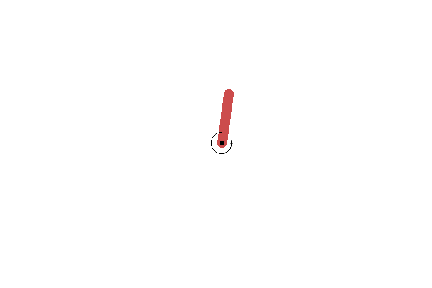
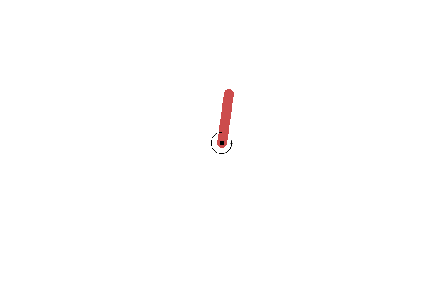
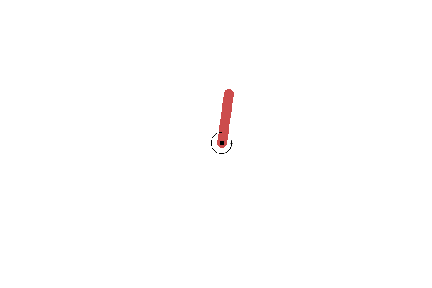
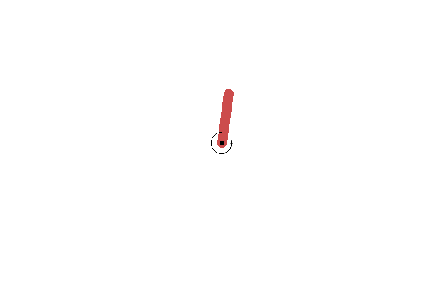
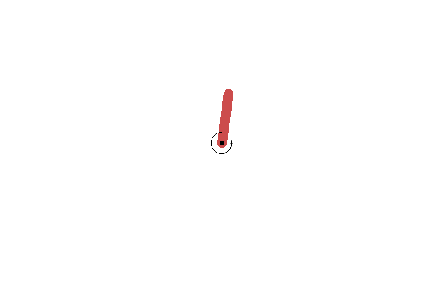
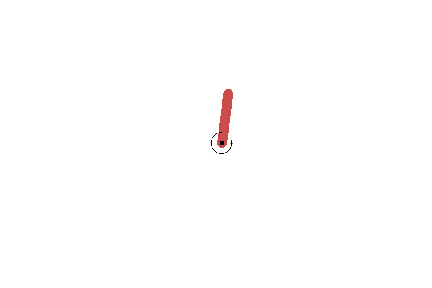
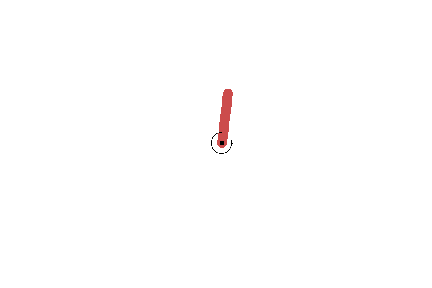
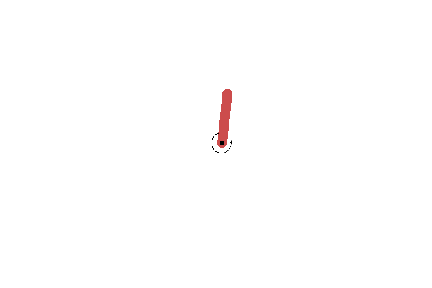
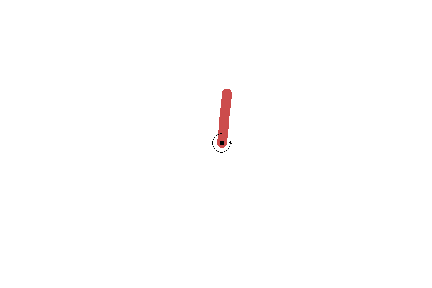
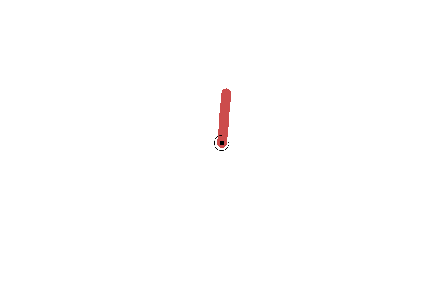
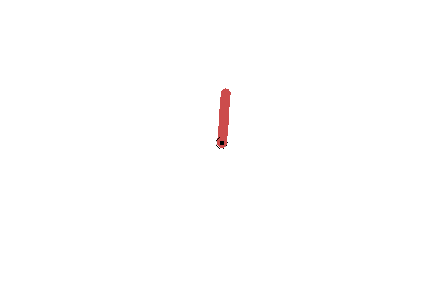
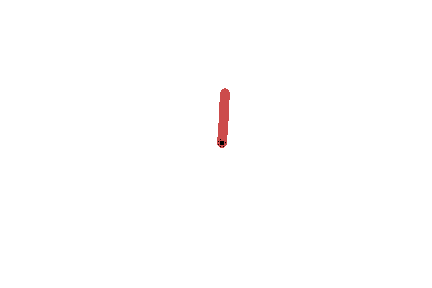
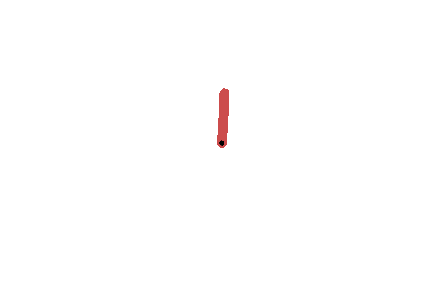
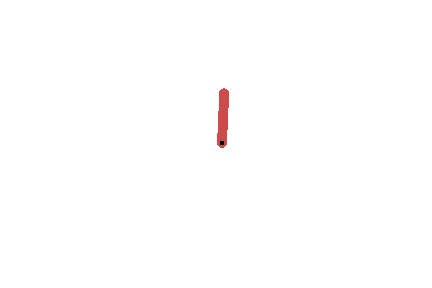
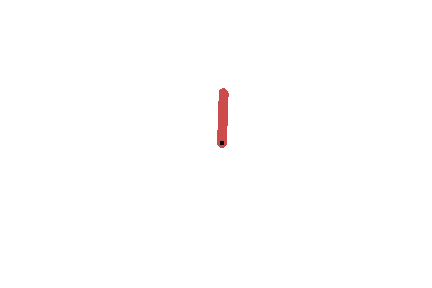
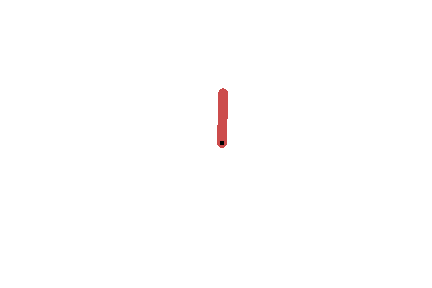
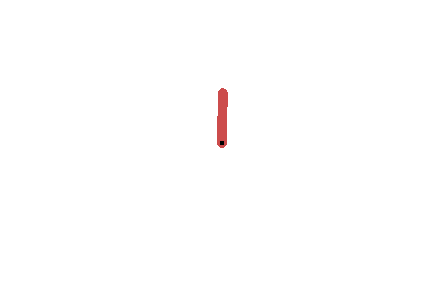
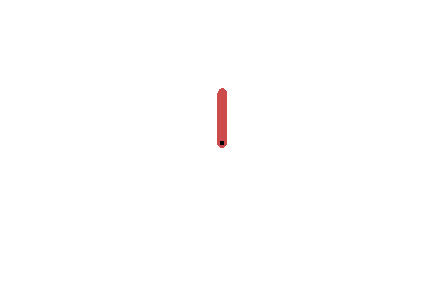
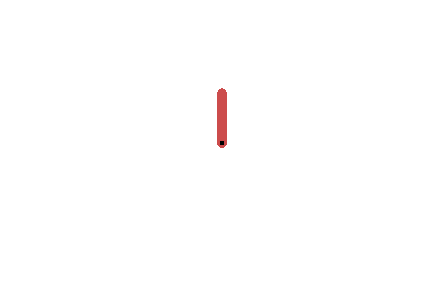
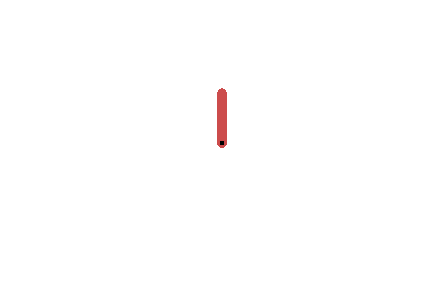
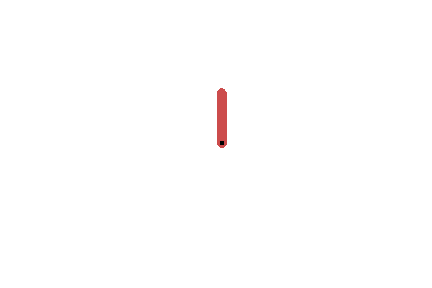
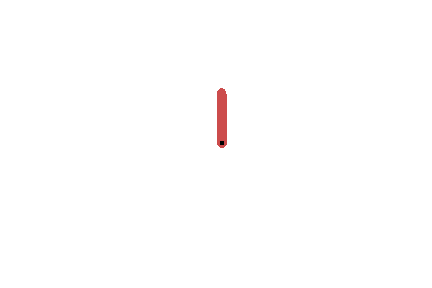
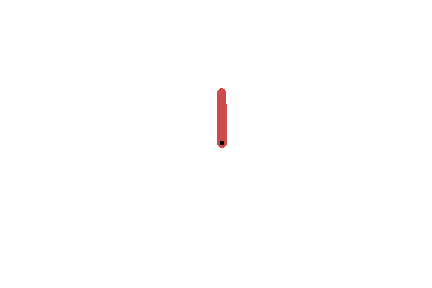
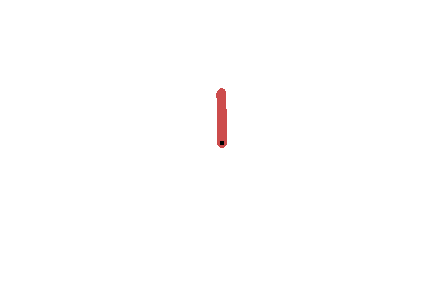
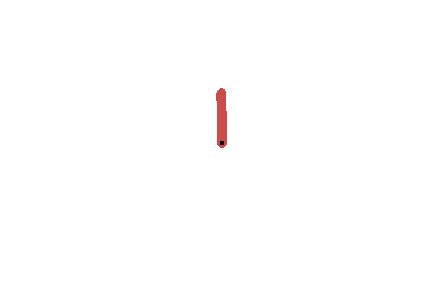
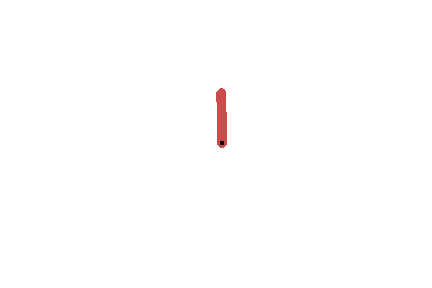
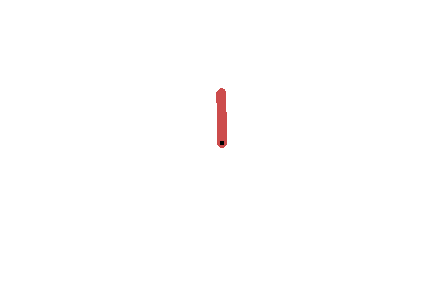
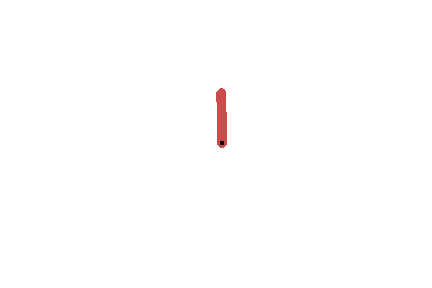
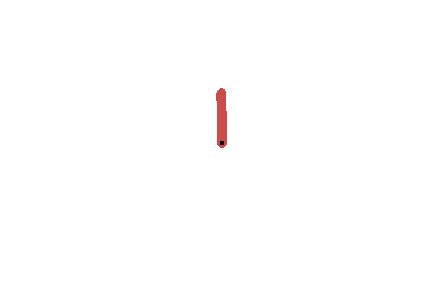
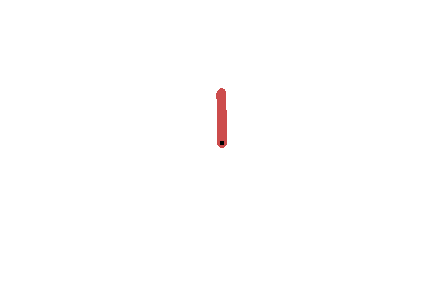
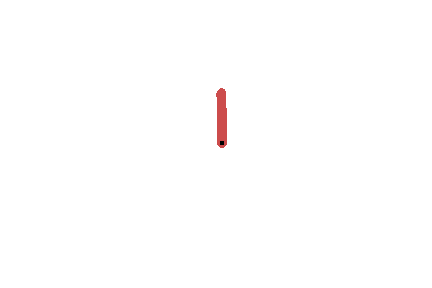
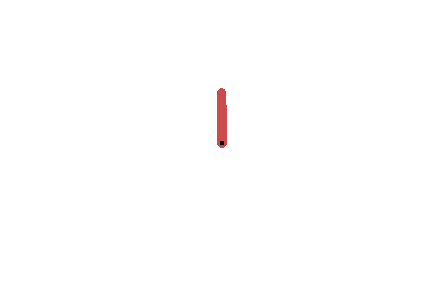
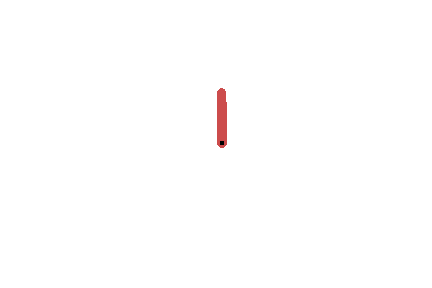
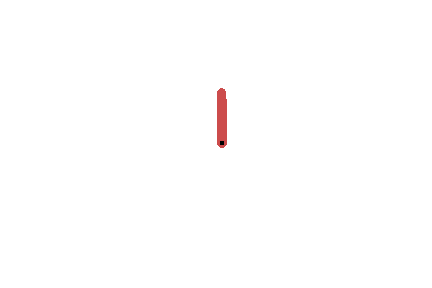
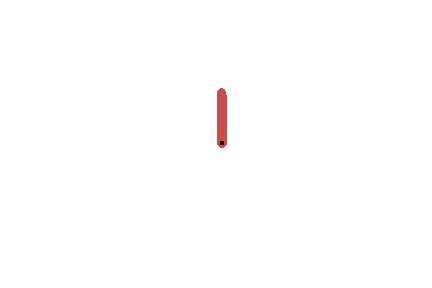
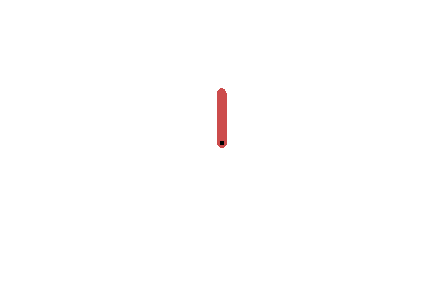
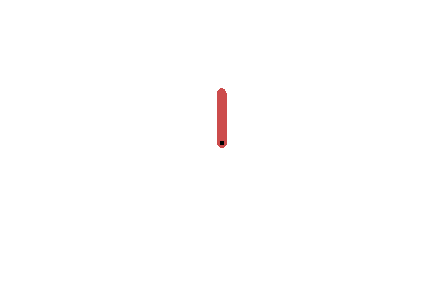
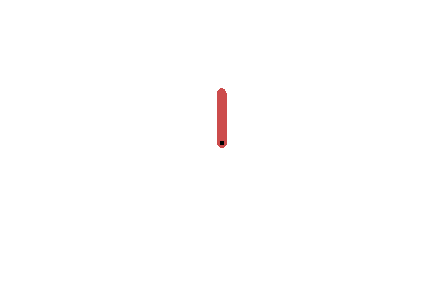
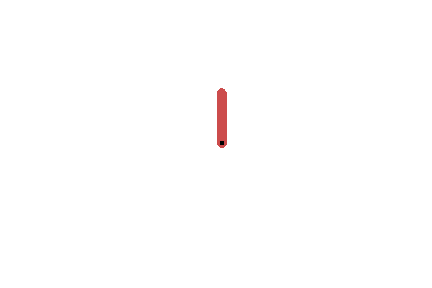
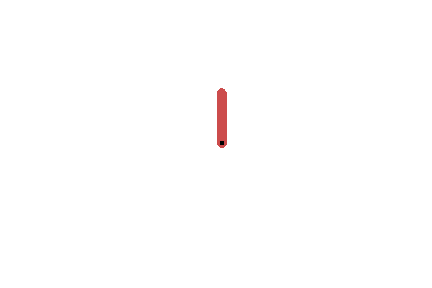
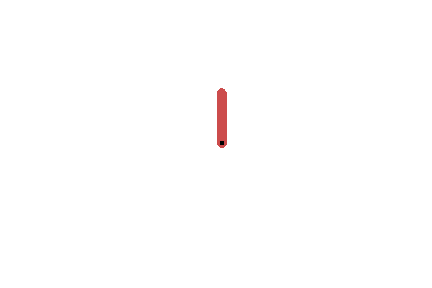
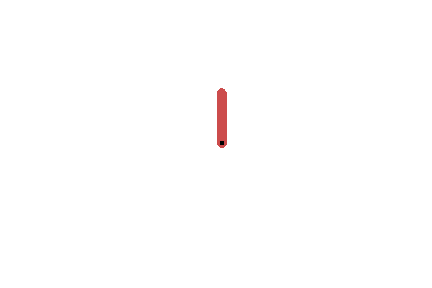
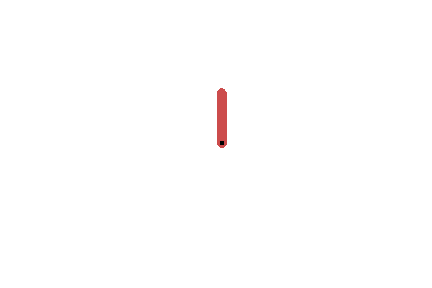
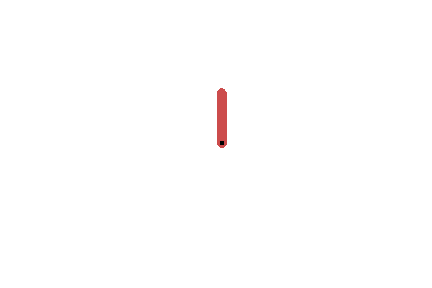
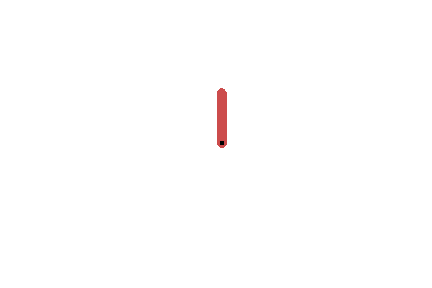
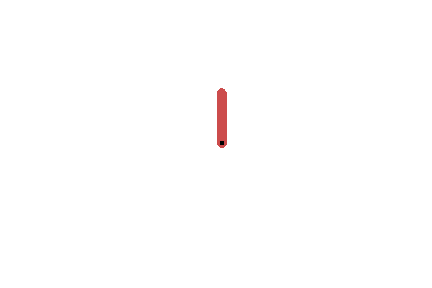
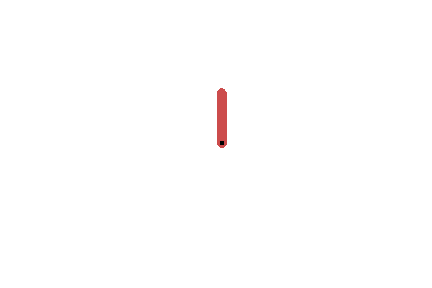
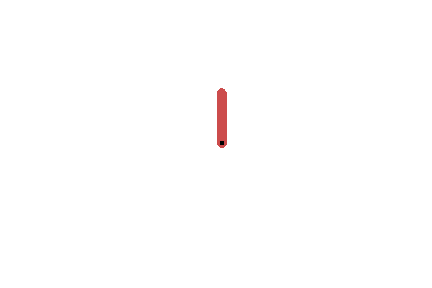
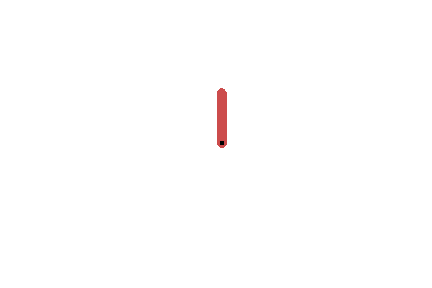
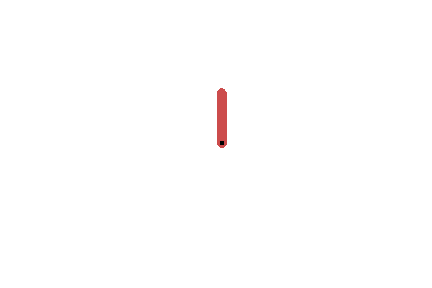
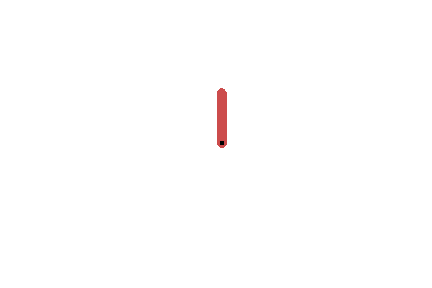
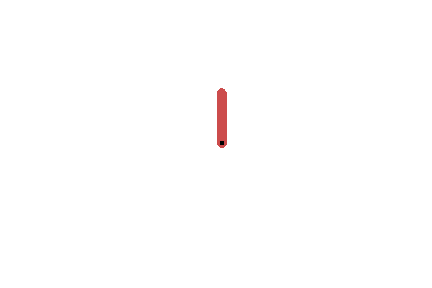
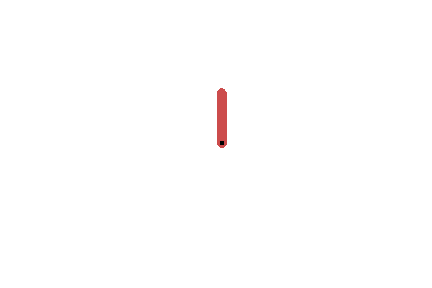
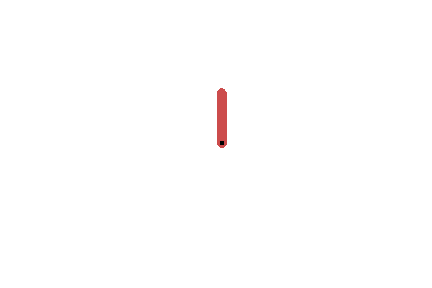
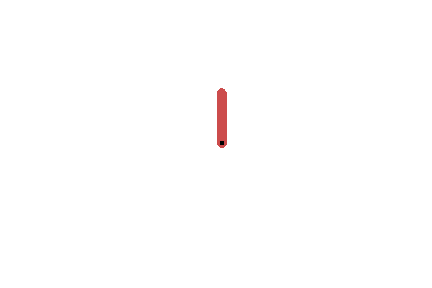
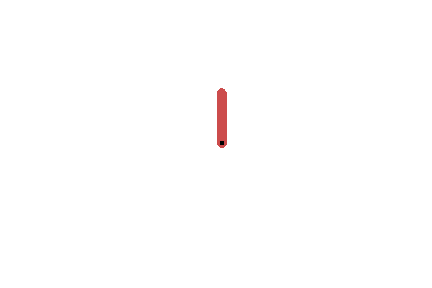
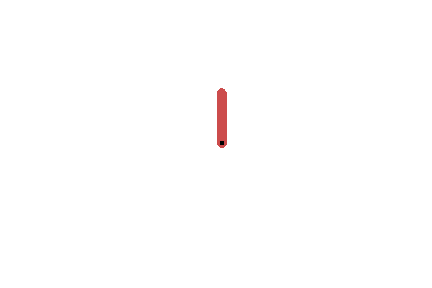
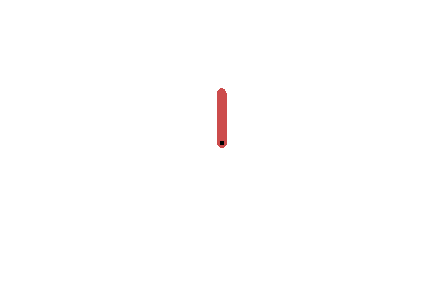
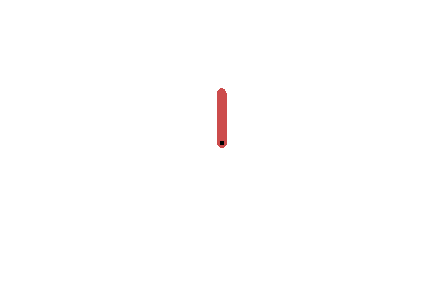
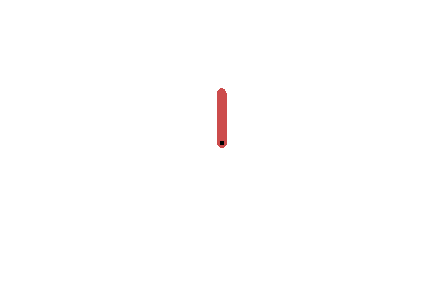
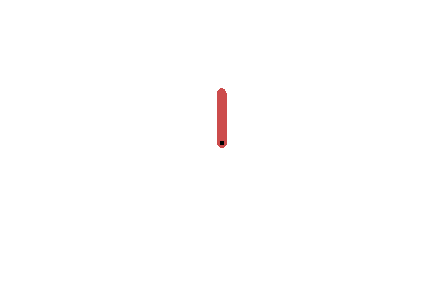
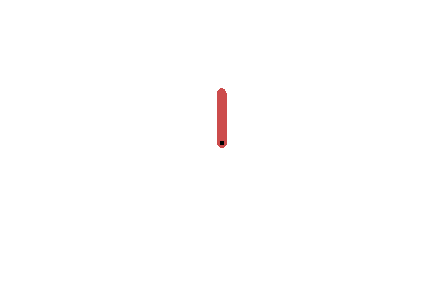
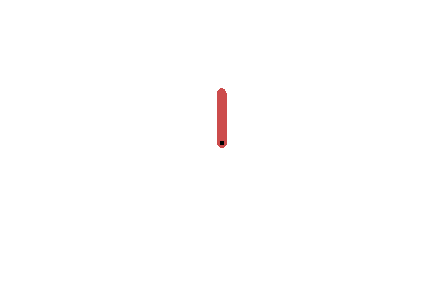
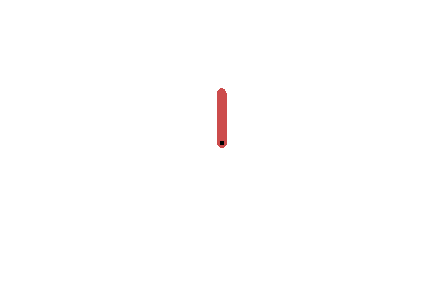
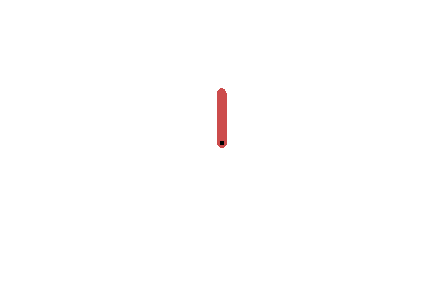
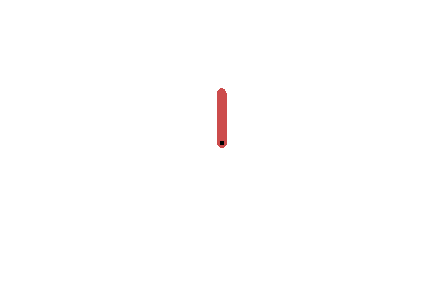
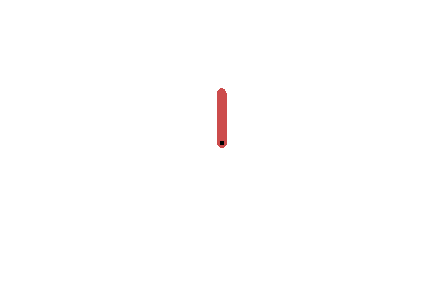
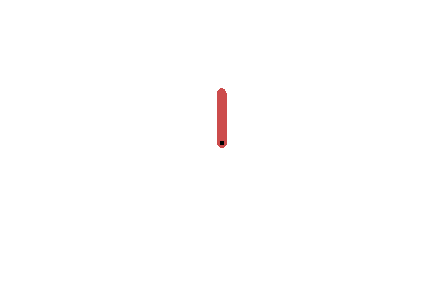
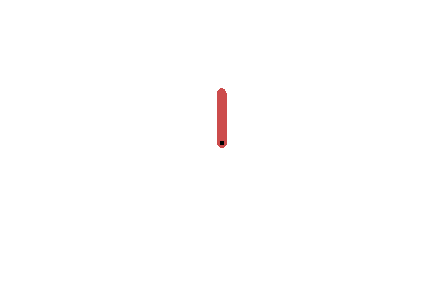
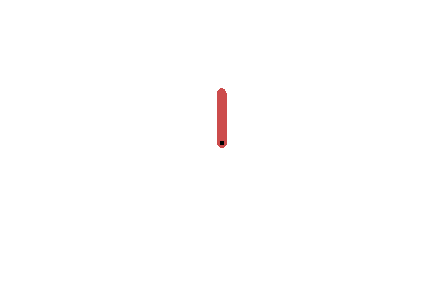
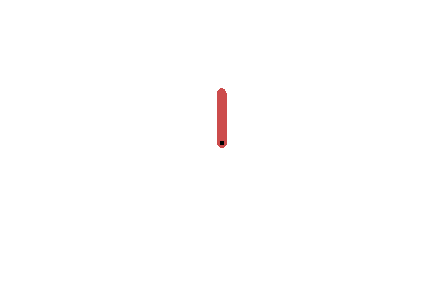
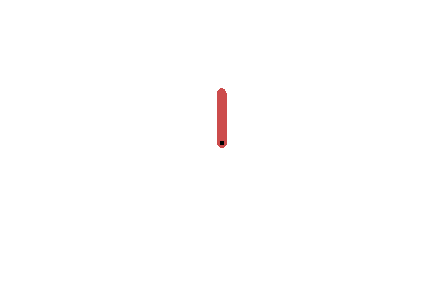
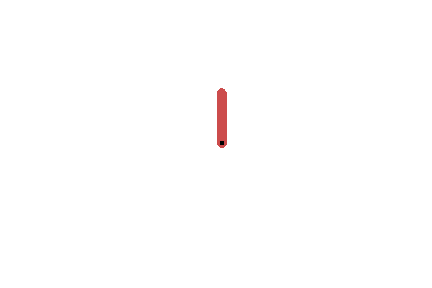
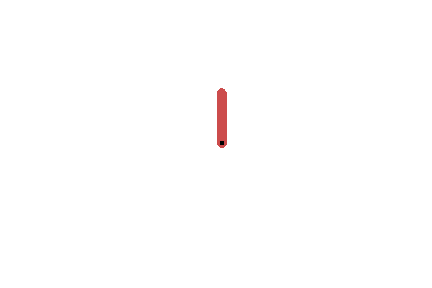
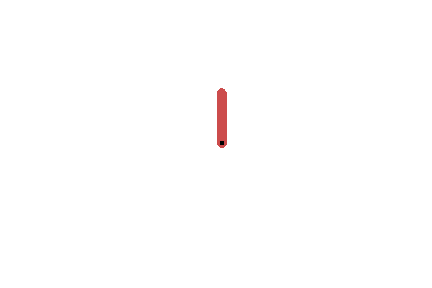
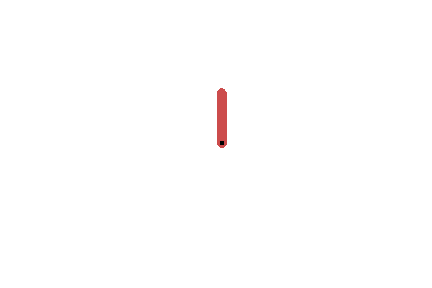
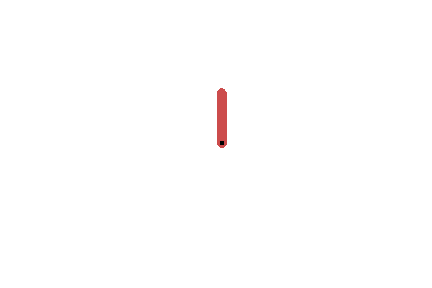
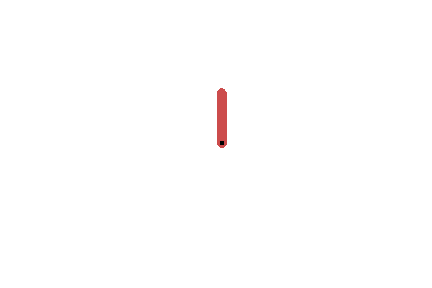
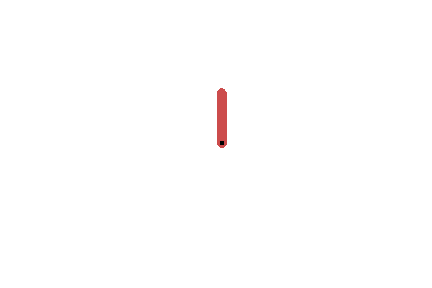
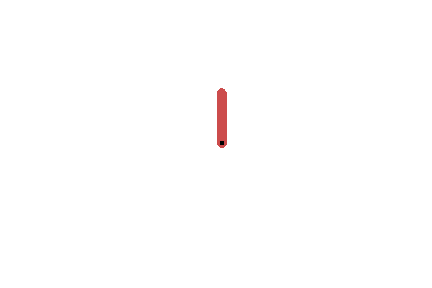
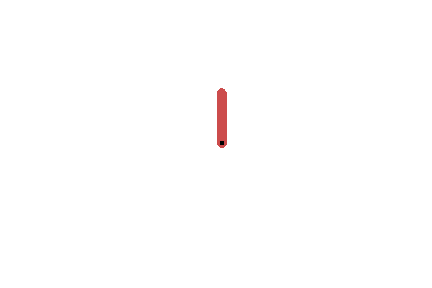
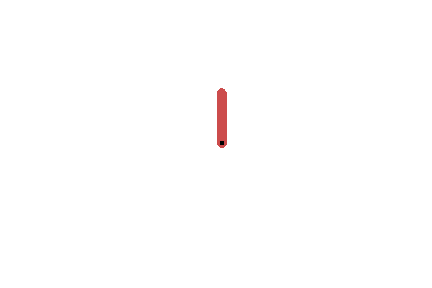
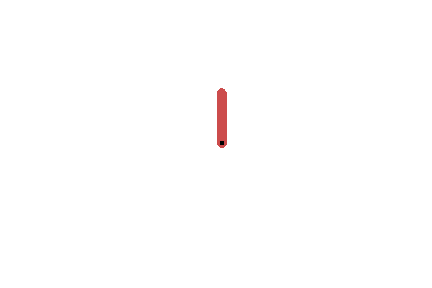
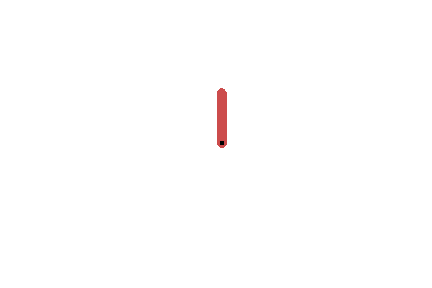
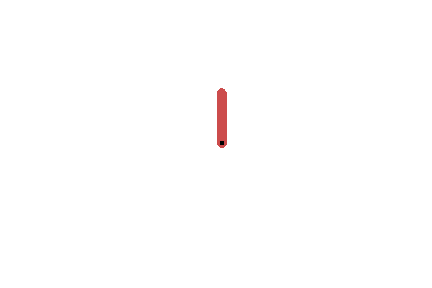
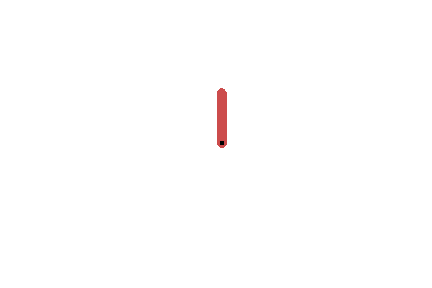
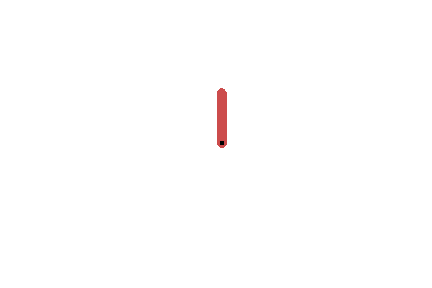
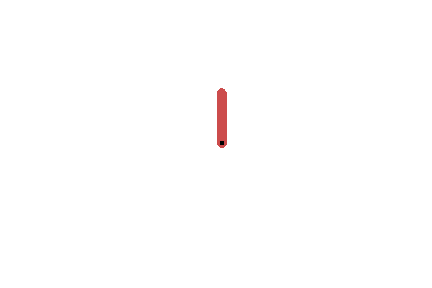
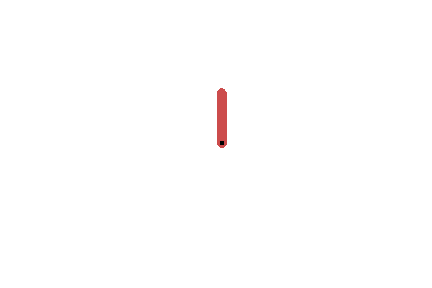
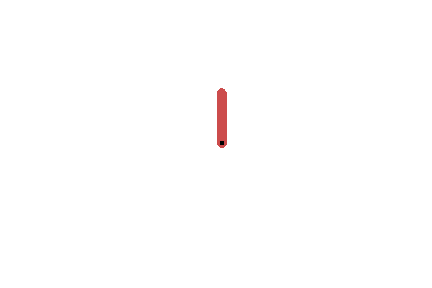
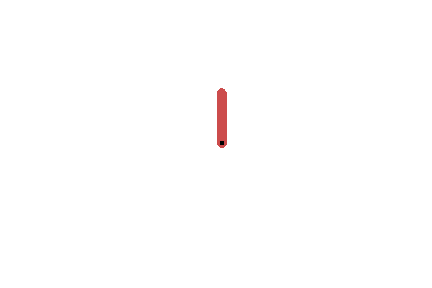
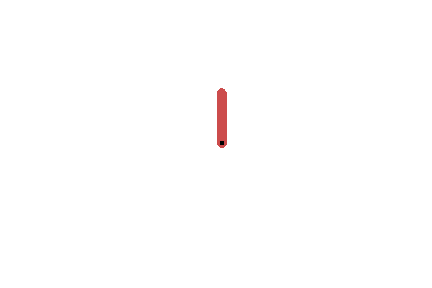
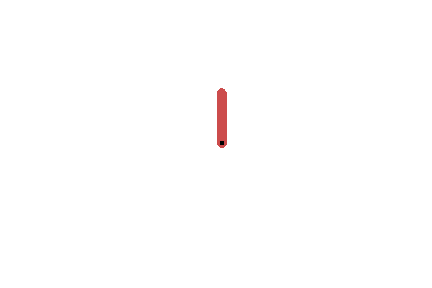
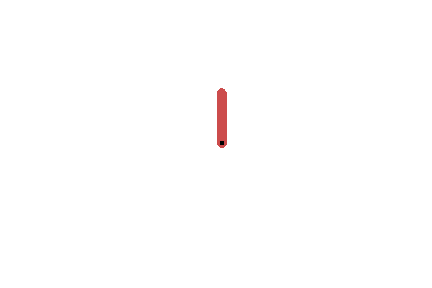
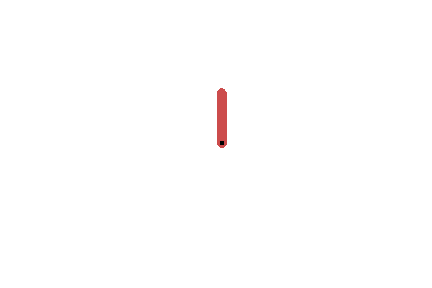
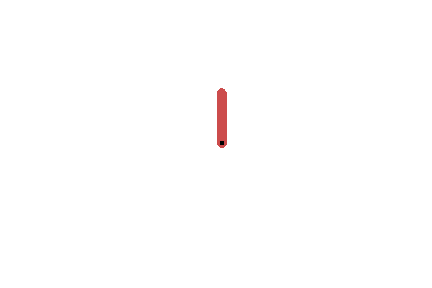
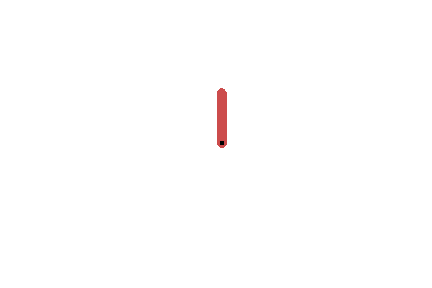
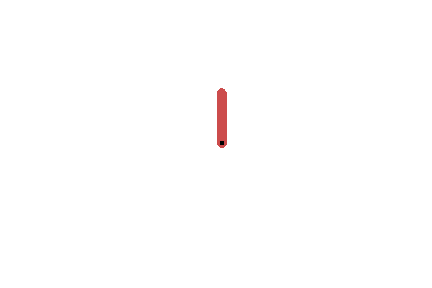
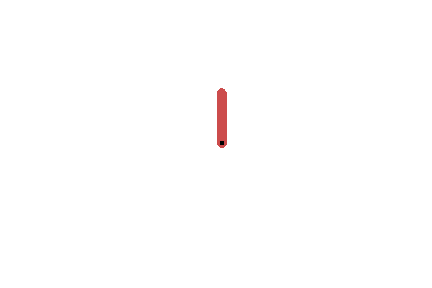
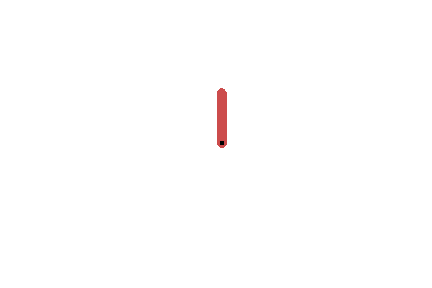
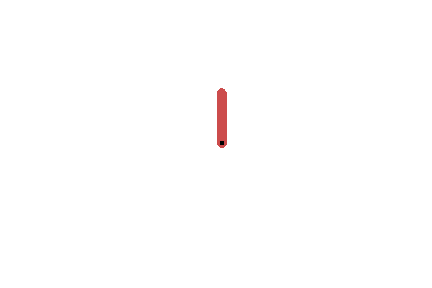
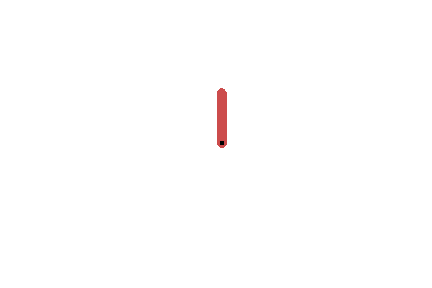
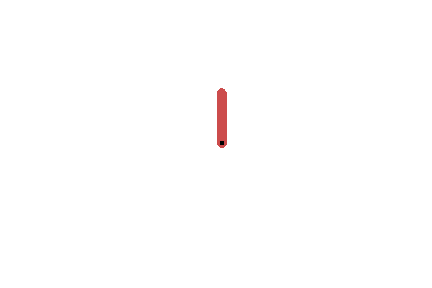
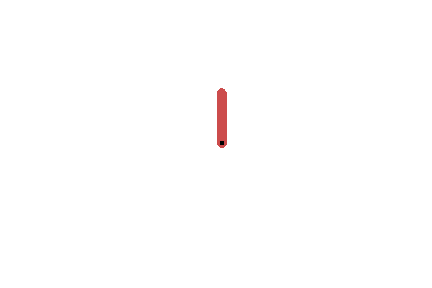
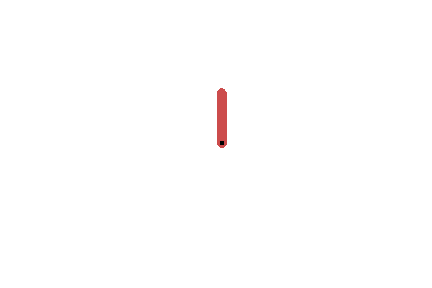
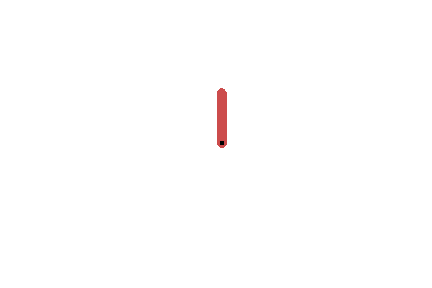
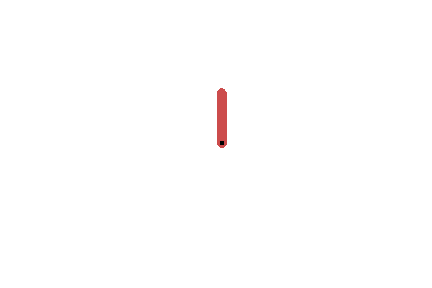
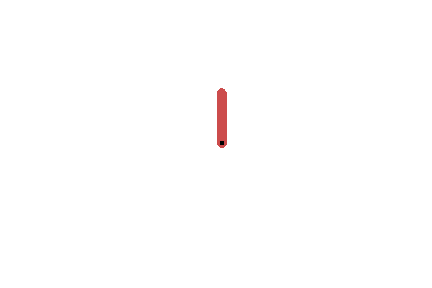
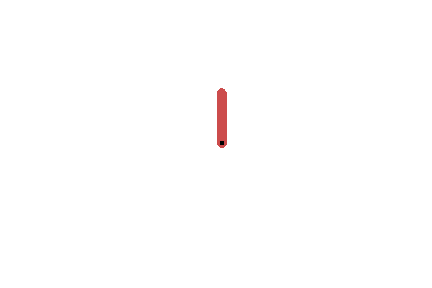
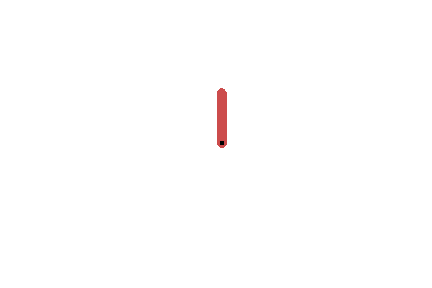
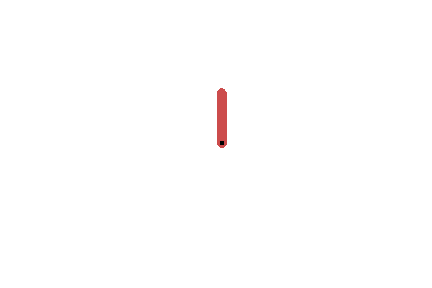
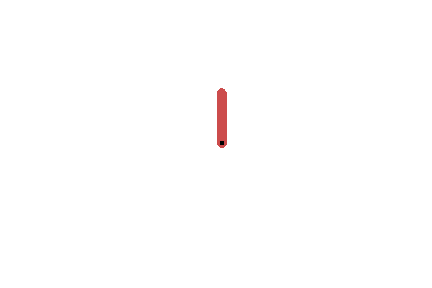
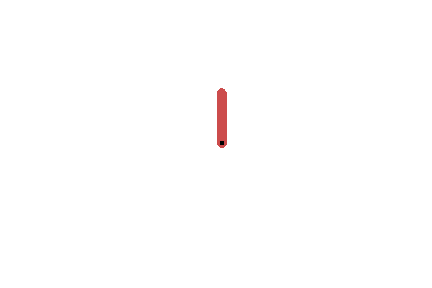
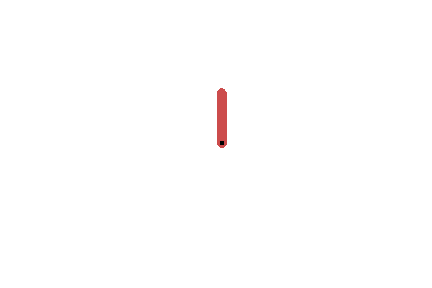
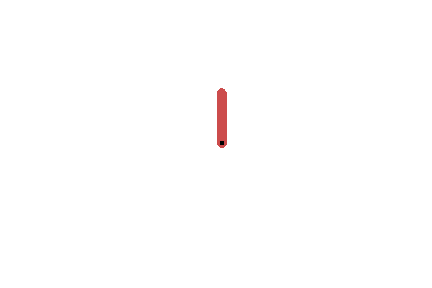
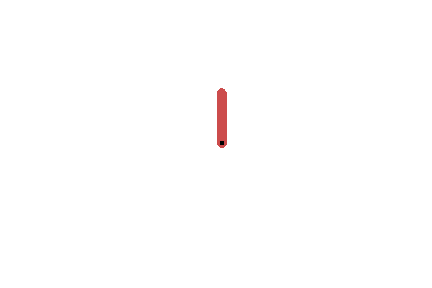
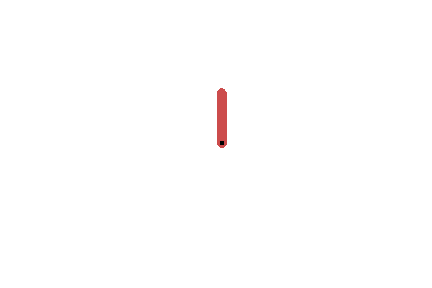
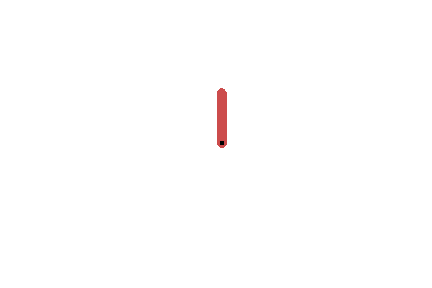
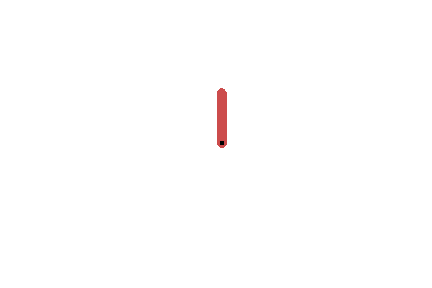
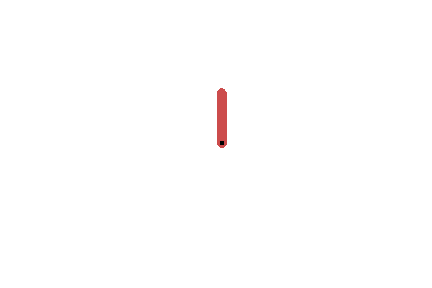
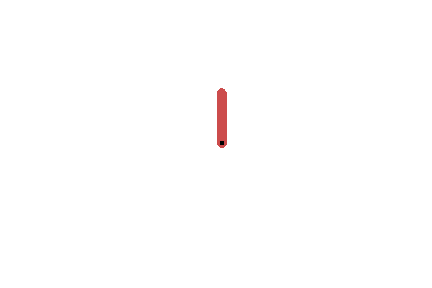
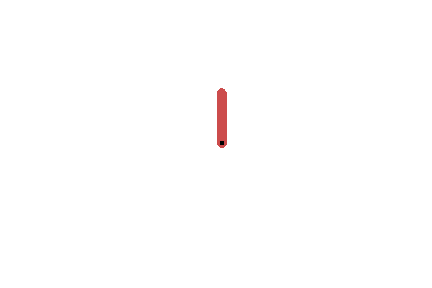
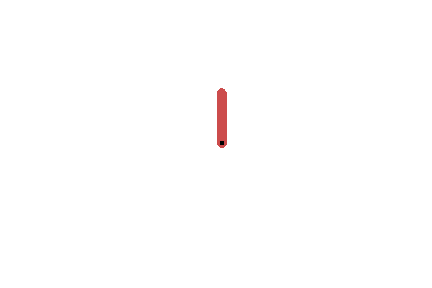
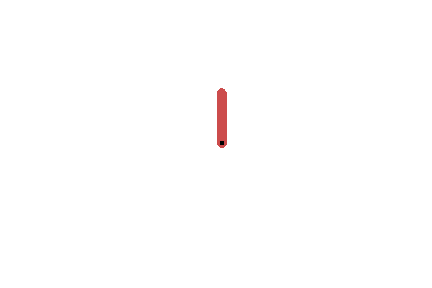
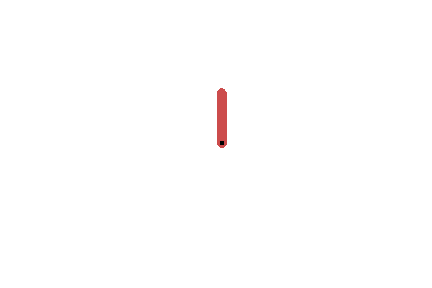
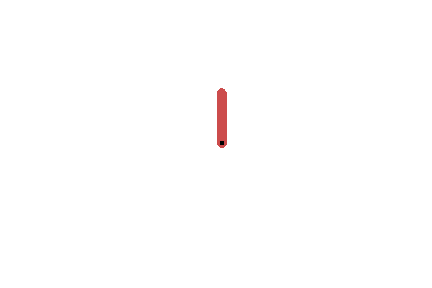
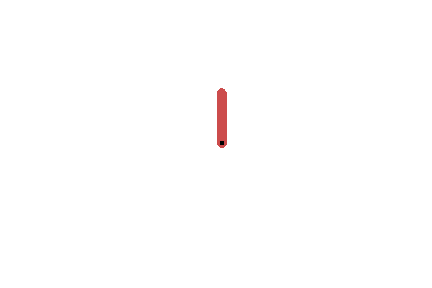
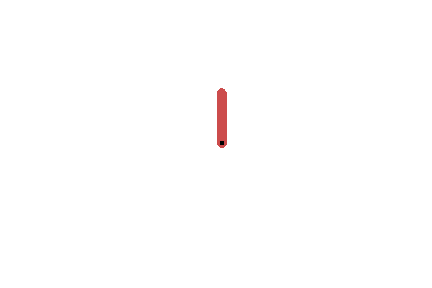
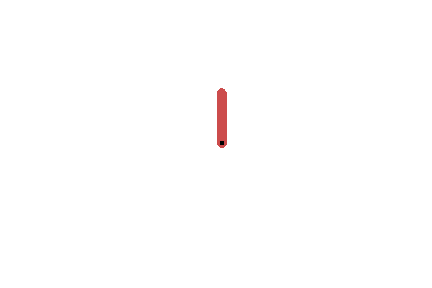
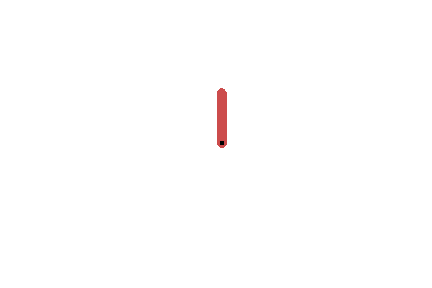
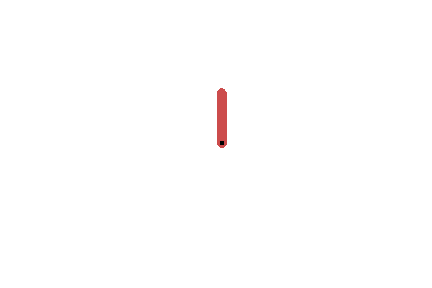
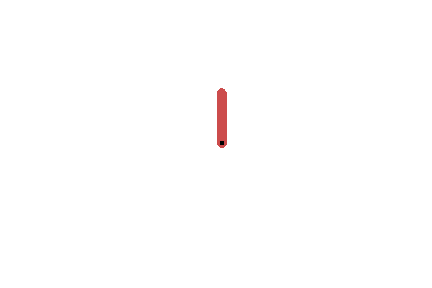
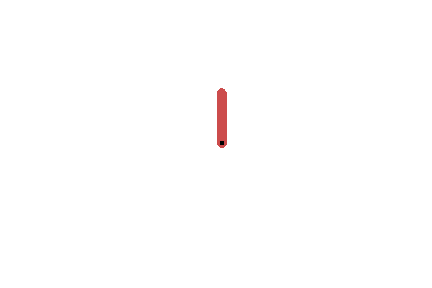
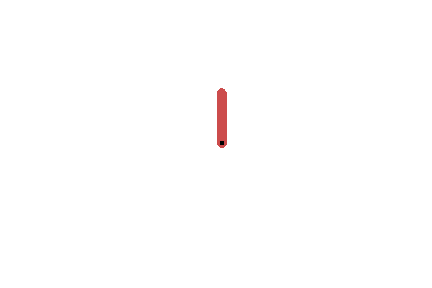
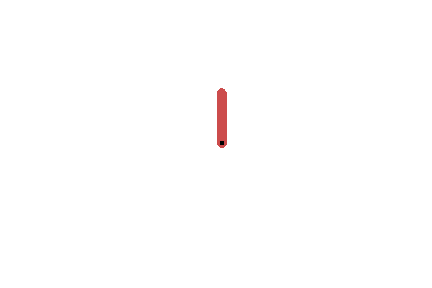
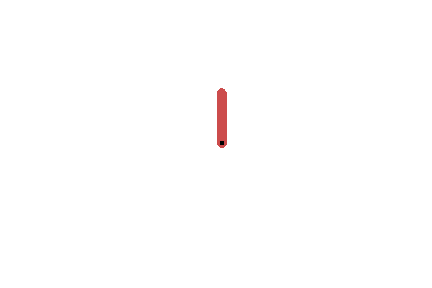
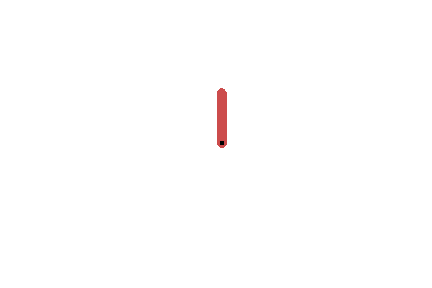
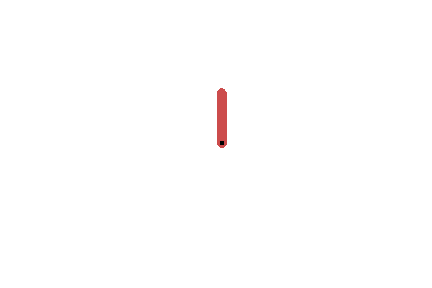
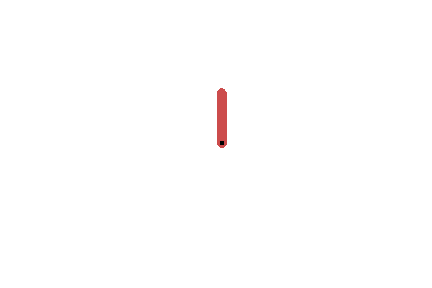
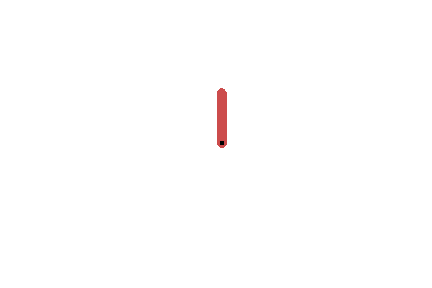
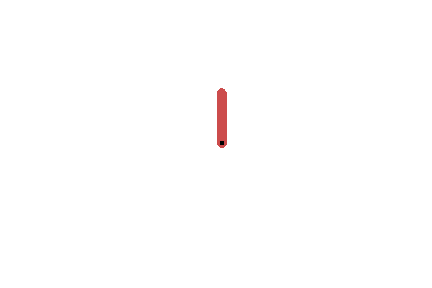
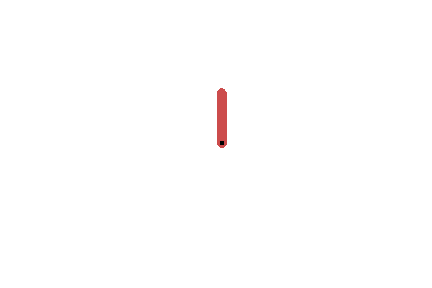
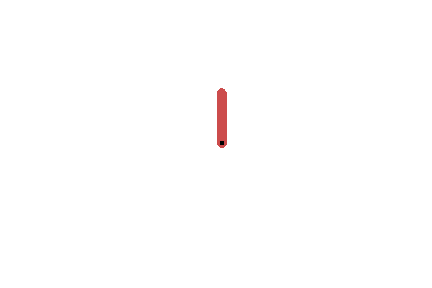
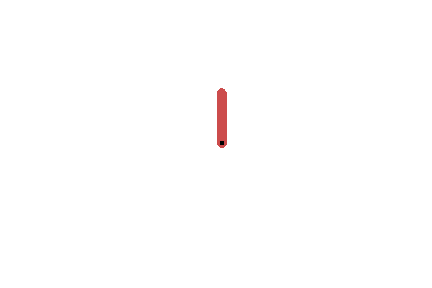
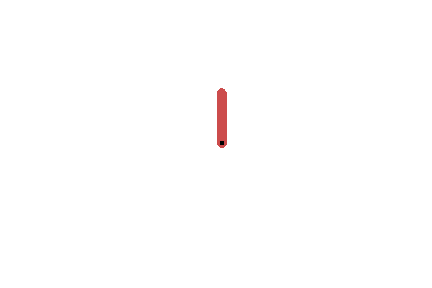
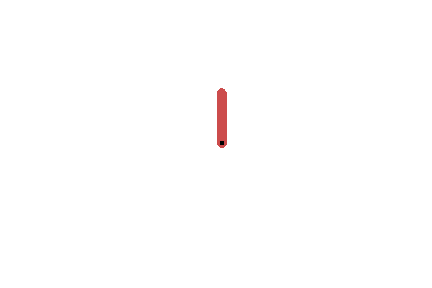
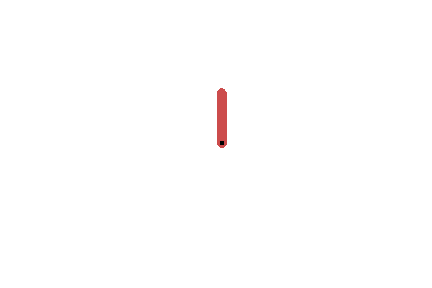
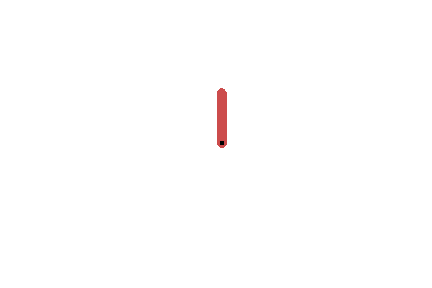
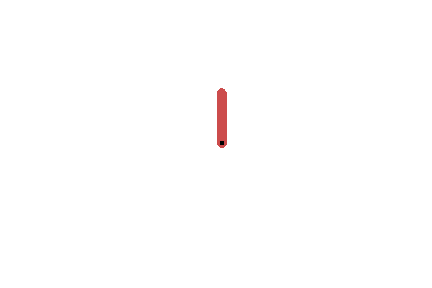
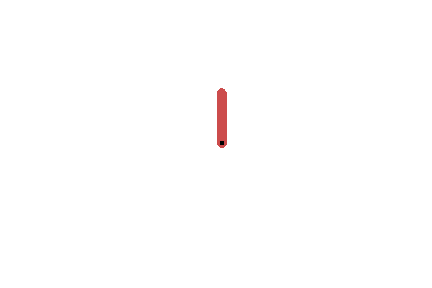
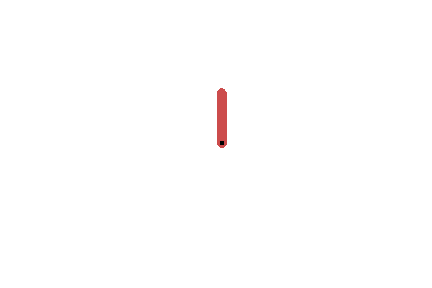
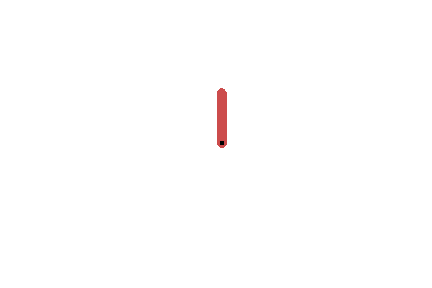
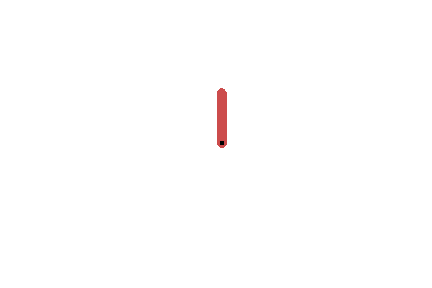
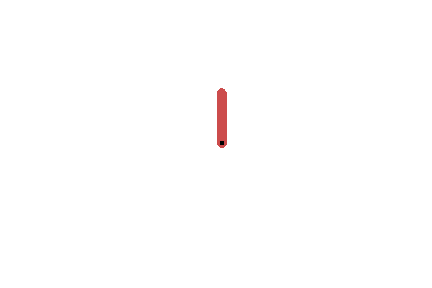
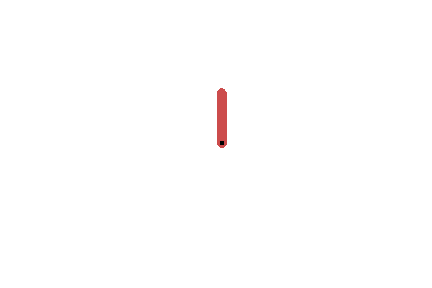
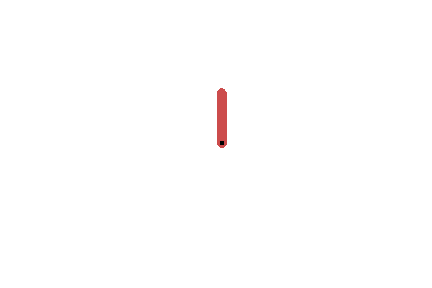
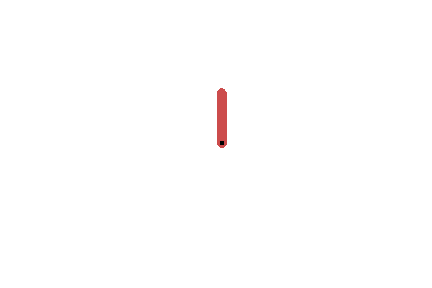
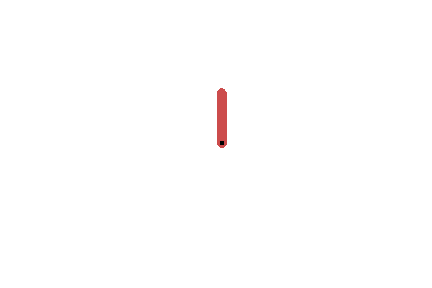
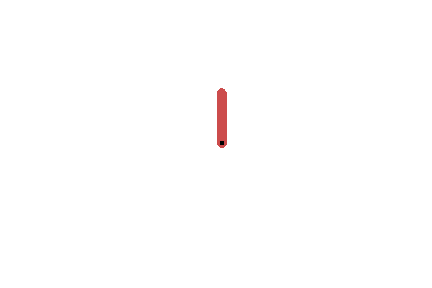
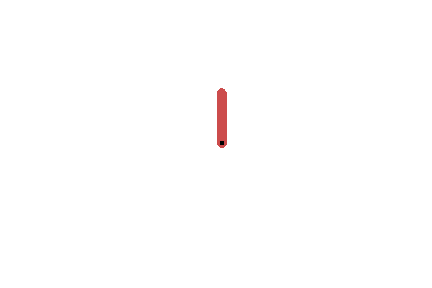
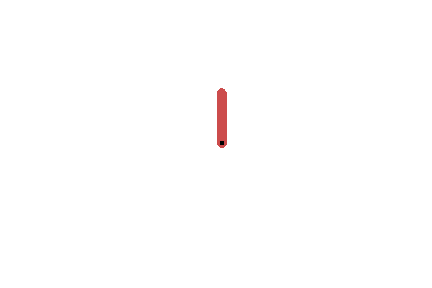

In [19]:
envname = 'Pendulum-v0'
env = gym.make(envname)
obs = env.reset()
total_reward = 0
frames = []
for t in range(10000):
    # Render into buffer. 
    frames.append(env.render(mode = 'rgb_array'))
    obs = obs.astype(np.float32).reshape((1, -1))
    action = actor.predict(np.reshape(obs, (1, actor.obs_dim)))
    obs, reward, done, info = env.step(action)
    total_reward += reward
    if done:
        break
env.close()
print('Total Reward : %.2f'%total_reward)

display_frames_as_gif(frames)